## **Step 0**: Log in to Hugging Face

In [1]:
!pip install huggingface_hub
!pip install ipywidgets
!pip install --upgrade transformers huggingface_hub accelerate

  Using cached huggingface_hub-1.1.2-py3-none-any.whl.metadata (13 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-win_amd64.whl.metadata (5.0 kB)
  Using cached httpx-0.28.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached pyyaml-6.0.3-cp311-cp311-win_amd64.whl.metadata (2.4 kB)
  Using cached shellingham-1.5.4-py2.py3-none-any.whl.metadata (3.5 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached typer_slim-0.20.0-py3-none-any.whl.metadata (16 kB)
  Using cached anyio-4.11.0-py3-none-any.whl.metadata (4.1 kB)
  Using cached certifi-2025.10.5-py3-none-any.whl.metadata (2.5 kB)
  Using cached httpcore-1.0.9-py3-none-any.whl.metadata (21 kB)
  Using cached idna-3.11-py3-none-any.whl.metadata (8.4 kB)
  Using cached h11-0.16.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached click-8.3.0-py3-none-any.whl.metadata (2.6 kB)
  Using cached sniffio-1.3.1-py3-none-any.whl.metadata (3.9 kB)
Using cached huggingface_hub-1.1.2-py3-none-any.whl (514 kB)
Using cached hf_xet-1


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.15-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.8-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.16-py3-none-any.whl (914 kB)
Using cached widgetsnbextension-4.0.15-py3-none-any.whl (2.2 MB)



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached transformers-4.57.1-py3-none-any.whl.metadata (43 kB)
  Using cached accelerate-1.11.0-py3-none-any.whl.metadata (19 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached regex-2025.11.3-cp311-cp311-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl.metadata (4.1 kB)
  Using cached charset_normalizer-3.4.4-cp311-cp311-win_amd64.whl.metadata (38 kB)
  Using cached urllib3-2.5.0-py3-none-any.whl.metadata (6.5 kB)
Using cached transformers-4.57.1-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached accelerate-1.11.0-py3-none-any.whl (375 kB)
Using cached regex-2025.11.3-cp311-cp311-win_amd64.whl (277 kB)
Using cached safetensors-0.6.2-cp38-abi3-win_amd64.whl (320 kB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## **Step 1**: Install Dependencies

In [4]:
!pip install transformers torch scikit-learn accelerate tqdm pandas openpyxl rouge-score nltk matplotlib -q

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Public\\Documents\\Team_Falcons_IR_final year\\.venv\\Lib\\site-packages\\pyparsing\\common.py'
Check the permissions.


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


^C


## **Step 2**: Imports and NLTK Download

In [8]:
import pandas as pd
import re
import os
import json
from typing import List, Dict, Tuple, Callable, Optional
from dataclasses import dataclass
import numpy as np
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from tqdm import tqdm
import sys
import argparse

# --- Import Scoring and Plotting Libraries ---
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import matplotlib.pyplot as plt

nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

## **Step 3**: Lightweight Model Wrapper (Generation Only)

In [9]:
class ModelGenerator:
    def __init__(self, model_name: str):
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            torch_dtype=torch.float16,
            device_map="auto"
        )
        self.device = self.model.device
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token

        self._layers_attr_path = self._find_layer_attr_path()
        self.num_layers = len(self._get_layers_list())
        print(f"[ModelGenerator] Model loaded. Path: {self._layers_attr_path}, Layers: {self.num_layers}")

    def _find_layer_attr_path(self):
        candidates = [["model", "layers"], ["transformer", "h"], ["model", "decoder", "layers"]]
        for path in candidates:
            cur = self.model
            valid = True
            for p in path:
                if hasattr(cur, p): cur = getattr(cur, p)
                else: valid = False; break
            if valid and isinstance(cur, (list, nn.ModuleList)): return path
        raise AttributeError("Could not find transformer layer list in model.")

    def _get_layers_list(self):
        cur = self.model
        for p in self._layers_attr_path: cur = getattr(cur, p)
        return list(cur)

    def generate(self, prompt: str, max_new_tokens: int = 150, **kwargs) -> str:
        tok = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
        input_token_len = tok.input_ids.shape[1]
        out = self.model.generate(**tok, max_new_tokens=max_new_tokens, pad_token_id=self.tokenizer.pad_token_id, **kwargs)
        full_tokens = out[0]
        new_tokens = full_tokens[input_token_len:]
        generated_text = self.tokenizer.decode(new_tokens, skip_special_tokens=True)
        return generated_text.strip()

## **Step 4**: Vector & Hook Definitions

In [12]:
# Style Vector Extraction Method (Mean Only)
def compute_mean_difference(pos: np.ndarray, neg: np.ndarray) -> np.ndarray:
    diff = (pos - neg).mean(axis=0)
    return diff / (np.linalg.norm(diff) + 1e-12)

# Steering Hook Class
class SteeringHook:
    def __init__(self, model, layer_path, layer_idx, style_vector, multiplier):
        self.model, self.layer_path, self.layer_idx = model, layer_path, layer_idx
        self.style_vector_cpu = torch.from_numpy(style_vector).float() * multiplier
        self.handle = None
        self._register_hook()

    def _get_layer_module(self):
        cur = self.model
        for p in self.layer_path: cur = getattr(cur, p)
        idx = self.layer_idx if self.layer_idx >= 0 else len(cur) + self.layer_idx
        return cur[idx]

    def _hook(self, module, input, output):
        tensor_output = output[0] if isinstance(output, tuple) else output
        add_vec = self.style_vector_cpu.to(tensor_output.device, dtype=tensor_output.dtype)
        modified_tensor = tensor_output + add_vec.view(1, 1, -1)
        return (modified_tensor,) + output[1:] if isinstance(output, tuple) else modified_tensor

    def _register_hook(self):
        self.handle = self._get_layer_module().register_forward_hook(self._hook)

    def remove(self):
        if self.handle: self.handle.remove()

## **Step 5**: Data Loading Function (for Test Set)

In [13]:
def load_data_for_testing(file_path: str, num_test: int = 20):
    """
    Loads data from the XLSX file and returns just the test set (first 20).
    """
    try:
        df = pd.read_excel(file_path)
    except Exception as e:
        print(f"An error occurred while reading the Excel file: {e}")
        return None

    # --- Check your column names here ---
    NEUTRAL_COL = 'response_Neutral'
    STYLED_COL = 'response_styled'
    # -----------------------------------

    required_cols = ['date', 'Time', 'Venue', 'OccasionType', 'Host', 'Event', NEUTRAL_COL, STYLED_COL]
    if not all(col in df.columns for col in required_cols):
        print(f"Error: Missing one of the required columns. Found: {df.columns}")
        return None

    print(f"INFO: Loaded {len(df)} examples from the file.")

    test_examples = []
    
    # Get only the first 20 examples for testing
    test_df = df.iloc[:num_test]

    for idx, row in test_df.iterrows():
        date = row.get('date', 'N/A')
        time_ = row.get('Time', 'N/A')
        venue = row.get('Venue', 'N/A')
        occasion = row.get('OccasionType', 'N/A')
        host = row.get('Host', 'N/A')
        event = row.get('Event', 'N/A')
        
        styled_email = row.get(STYLED_COL)

        if pd.isna(styled_email):
            continue

        prompt = f"""
Write an email inviting participants to the following event.
Ensure the email tone matches the style instruction and stays under 100 words.

Event Details:
- Date: {date}
- Time: {time_}
- Venue: {venue}
- Occasion Type: {occasion}
- Host: {host}
- Event: {event}
"""
        test_examples.append((prompt, styled_email))

    print(f"Loaded {len(test_examples)} examples for testing.")
    
    test_hist = {"user_1": test_examples} 

    return test_hist

## **Step 6**: Run Evaluation

Running Evaluation: model=meta-llama/Llama-2-7b-hf, layer=-15
INFO: Loaded 41 examples from the file.
Loaded 20 examples for testing.
Activations loaded successfully from 'activations.npz'
[Pipeline] Computed style vector.


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu and disk.


[ModelGenerator] Model loaded. Path: ['model', 'layers'], Layers: 32

Hyperparameter Evaluation (Mean Difference)
Testing on the first 20 examples


Testing multipliers: 100%|██████████| 6/6 [4:49:47<00:00, 2897.93s/it]  



Evaluation Results (Average F1-Score)
Multiplier   | Avg. ROUGE-L    | Avg. METEOR    
--------------------------------------------
0.5          | 0.1999          | 0.2071         
1.0          | 0.1750          | 0.1732         
1.5          | 0.1659          | 0.1792         
2.0          | 0.1615          | 0.1349         
2.5          | 0.1957          | 0.1887         
3.0          | 0.2024          | 0.1961         

Performance Graph
Graph saved as 'hyperparameter_tuning_graph.png'


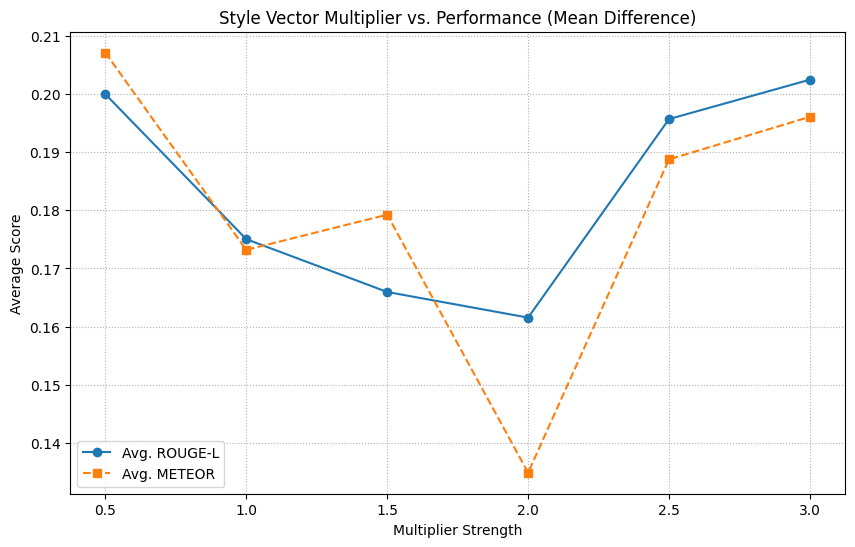


Pipeline finished successfully.


In [14]:
if __name__ == "__main__":
    if 'ipykernel' in sys.modules: sys.argv = sys.argv[:1]

    parser = argparse.ArgumentParser()
    parser.add_argument("--model", type=str, default="meta-llama/Llama-2-7b-hf")
    parser.add_argument("--layer", type=int, default=-15)
    parser.add_argument("--xlsx_file", type=str, default="generated_email_responses (1).xlsx")
    parser.add_argument("--input_file", type=str, default="activations.npz")
    args = parser.parse_args()

    print(f"Running Evaluation: model={args.model}, layer={args.layer}")

    # 1. Load test data
    test_hist = load_data_for_testing(args.xlsx_file, num_test=20)
    if not test_hist:
        print("Halting execution due to data loading error.")
    else:
        # 2. Load the saved activations
        try:
            data = np.load(args.input_file)
            pos_arr = data['pos_acts']
            neg_arr = data['neg_acts']
            print(f"Activations loaded successfully from '{args.input_file}'")
        except FileNotFoundError:
            print(f"Error: The file '{args.input_file}' was not found.")
            print("Please run the '1_Extract_Activations.ipynb' script first.")
            sys.exit(1)
        except Exception as e:
            print(f"An error occurred loading activations: {e}")
            sys.exit(1)

        # 3. Compute Style Vector (Mean Difference Only)
        mean_style_vector = compute_mean_difference(pos_arr, neg_arr)
        print("[Pipeline] Computed style vector.")

        # 4. Load the model for generation
        ae_gen = ModelGenerator(args.model)

        # 5. Run Automated Evaluation for Hyperparameters
        print("\n" + "="*50)
        print("Hyperparameter Evaluation (Mean Difference)")
        print(f"Testing on the first {len(test_hist['user_1'])} examples")
        print("="*50)
        
        scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
        
        multipliers_to_test = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
        scores = {m: {"rougeL": [], "meteor": []} for m in multipliers_to_test}
        test_examples = test_hist["user_1"]
        
        for multiplier in tqdm(multipliers_to_test, desc="Testing multipliers"):
            for (inp_prompt, ideal_user_email) in test_examples:
                ideal_tokens = nltk.word_tokenize(ideal_user_email)
                if not ideal_tokens: ideal_tokens = [""]
                
                hook = SteeringHook(ae_gen.model, ae_gen._layers_attr_path, args.layer, mean_style_vector, multiplier)
                try:
                    steered_out_email = ae_gen.generate(inp_prompt, temperature=0.7, do_sample=True, top_p=0.9)
                    
                    rouge_scores = scorer.score(ideal_user_email, steered_out_email)
                    scores[multiplier]["rougeL"].append(rouge_scores['rougeL'].fmeasure)
                    
                    steered_tokens = nltk.word_tokenize(steered_out_email)
                    if not steered_tokens: steered_tokens = [""]
                    meteor = meteor_score([ideal_tokens], steered_tokens)
                    scores[multiplier]["meteor"].append(meteor)
                finally:
                    hook.remove()

        # 6. Print Final Results Table
        print("\n" + "="*50)
        print("Evaluation Results (Average F1-Score)")
        print("="*50)
        print(f"{'Multiplier':<12} | {'Avg. ROUGE-L':<15} | {'Avg. METEOR':<15}")
        print("-" * 44)
        
        avg_rouge_scores = []
        avg_meteor_scores = []
        
        for multiplier in multipliers_to_test:
            avg_rouge = np.mean(scores[multiplier]['rougeL'])
            avg_meteor = np.mean(scores[multiplier]['meteor'])
            avg_rouge_scores.append(avg_rouge)
            avg_meteor_scores.append(avg_meteor)
            print(f"{multiplier:<12.1f} | {avg_rouge:<15.4f} | {avg_meteor:<15.4f}")

        # 7. Plot Final Results Graph
        print("\n" + "="*50)
        print("Performance Graph")
        print("="*50)
        
        plt.figure(figsize=(10, 6))
        plt.plot(multipliers_to_test, avg_rouge_scores, marker='o', linestyle='-', label='Avg. ROUGE-L')
        plt.plot(multipliers_to_test, avg_meteor_scores, marker='s', linestyle='--', label='Avg. METEOR')
        plt.title('Style Vector Multiplier vs. Performance (Mean Difference)')
        plt.xlabel('Multiplier Strength')
        plt.ylabel('Average Score')
        plt.xticks(multipliers_to_test)
        plt.legend()
        plt.grid(True, linestyle=':')
        plt.savefig("hyperparameter_tuning_graph.png") # Save the plot as a file
        print("Graph saved as 'hyperparameter_tuning_graph.png'")
        plt.show()
        
        print("\nPipeline finished successfully.")